In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np

from PIL import Image
from torchvision.transforms import ToTensor
from torchvision import transforms
import glob
import torch.nn.functional as F
import torch.nn as nn
from matplotlib import cm
plt.style.use('dark_background')

In [2]:
def changeSize(img, size):
    # utiliser torch.narrow pour rendre les images carré ou CenterCrop
    p = transforms.Compose([transforms.Scale(size)])
    return p(img)

In [3]:
tensor_list = []
for filename in glob.glob('Datasets/OldV2/*.jpg'):
    image=Image.open(filename)
    tensor_list.append(ToTensor()(image))
OldTens = torch.stack(tensor_list)

In [4]:
tensor_list = []
for filename in glob.glob('Datasets/YoungV2/*.jpg'):
    image=Image.open(filename)
    tensor_list.append(ToTensor()(image))
YoungTens = torch.stack(tensor_list)

In [5]:
YoungTens.shape

torch.Size([1864, 3, 200, 200])

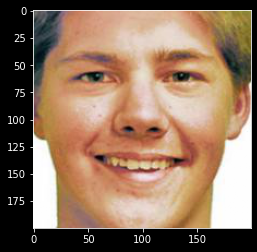

In [6]:
plt.imshow(YoungTens[0].permute(1,2,0))

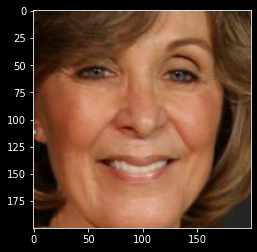

In [7]:
plt.imshow(OldTens[600].permute(1,2,0))

In [8]:
class Residual(nn.Module):
    def __init__(self, chan):
        super().__init__()
        self.residual1 = nn.Conv2d(chan, chan, 3, stride = 1, padding = 1)
        self.residual2 = nn.Conv2d(chan, chan, 3, stride = 1, padding = 1)
        
        self.norm1 = nn.InstanceNorm2d(chan)
        self.norm2 = nn.InstanceNorm2d(chan)
        
    def forward(self, x):
        h = F.leaky_relu(self.norm1(self.residual1(x)), 0.2)
        return x + self.norm2(self.residual2(h))

In [9]:
class ConvB(nn.Module):
    def __init__(self, in_chan, out_chan, ksize, stride, padding, act = True, normB = True):
        super().__init__()
        self.act = act
        self.normB = normB
        self.id = nn.Identity()
        self.conv = nn.Conv2d(in_chan, out_chan, ksize, stride, padding)
        self.norm = nn.InstanceNorm2d(out_chan)
    
    def forward(self, x):
        x = self.conv(x)
        if self.normB == True: 
            x = self.norm(x) 
        else: 
            x = self.id(x)
        if self.act == True:
            x = F.leaky_relu(x, 0.2) 
        else: 
            x = self.id(x)
        return x       

In [10]:
class ConvTransB(nn.Module):
    def __init__(self, in_chan, out_chan, ksize, stride, padding, act = True, normB = True):
        super().__init__()
        self.act = act
        self.normB = normB
        self.id = nn.Identity()
        self.convtrans = nn.ConvTranspose2d(in_chan, out_chan, ksize, stride, padding)
        self.norm = nn.InstanceNorm2d(out_chan)
    
    def forward(self, x):
        x = self.convtrans(x)
        if self.normB == True: 
            x = self.norm(x) 
        else: 
            x = self.id(x)
        if self.act == True:
            x = F.leaky_relu(x, 0.2) 
        else: 
            x = self.id(x)
        return x    

In [11]:
class GeneratorYoungToOld(nn.Module):
    def __init__(self):
        super(GeneratorYoungToOld, self).__init__() #3*200*200
        self.conv1 = ConvB(3, 64, 7, 1, 3) #64*200*200
        self.conv2 = ConvB(64, 128, 4, 2, 1) #128*100*100
        self.conv3 = ConvB(128, 256, 4, 2, 1) #256*50*50
        
        self.residual1 = Residual(256)
        self.residual2 = Residual(256)
        self.residual3 = Residual(256)
        self.residual4 = Residual(256)
        self.residual5 = Residual(256)
        self.residual6 = Residual(256)
        self.residual7 = Residual(256)
        self.residual8 = Residual(256)
        self.residual9 = Residual(256)
        
        self.convtrans1 = ConvTransB(256, 128, 4, 2, 1) #128*50*50
        self.conv6 = ConvB(128, 128, 5, 1, 2) #128*100*100
        self.convtrans2 = ConvTransB(128, 64, 4, 2, 1) #64*200*200
        self.conv7 = ConvB(64, 3, 7, 1, 3, act = False, normB = False) #3*200*200

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)

        x = self.residual1(x)
        x = self.residual2(x)
        x = self.residual3(x)
        x = self.residual4(x)
        x = self.residual5(x)
        x = self.residual6(x)
        x = self.residual7(x)
        x = self.residual8(x)
        x = self.residual9(x)
        
        x = self.convtrans1(x)
        x = self.conv6(x)
        x = self.convtrans2(x)
        x = self.conv7(x)
        
        
        return x

In [12]:
gen = GeneratorYoungToOld()
batch = torch.unsqueeze(YoungTens[0], 0).float()
outold = gen.forward(batch)
outold.shape

torch.Size([1, 3, 200, 200])

In [13]:
class GeneratorOldToYoung(nn.Module):
    def __init__(self):
        super(GeneratorOldToYoung, self).__init__() #3*200*200
        self.conv1 = ConvB(3, 64, 7, 1, 3) #64*200*200
        self.conv2 = ConvB(64, 128, 4, 2, 1) #128*100*100
        self.conv3 = ConvB(128, 256, 4, 2, 1) #256*50*50
        
        self.residual1 = Residual(256)
        self.residual2 = Residual(256)
        self.residual3 = Residual(256)
        self.residual4 = Residual(256)
        self.residual5 = Residual(256)
        self.residual6 = Residual(256)
        self.residual7 = Residual(256)
        self.residual8 = Residual(256)
        self.residual9 = Residual(256)
        
        self.convtrans1 = ConvTransB(256, 128, 4, 2, 1) #128*50*50
        self.conv6 = ConvB(128, 128, 5, 1, 2) #128*100*100
        self.convtrans2 = ConvTransB(128, 64, 4, 2, 1) #64*200*200
        self.conv7 = ConvB(64, 3, 7, 1, 3, act = False, normB = False) #3*200*200

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)

        x = self.residual1(x)
        x = self.residual2(x)
        x = self.residual3(x)
        x = self.residual4(x)
        x = self.residual5(x)
        x = self.residual6(x)
        x = self.residual7(x)
        x = self.residual8(x)
        x = self.residual9(x)
        
        x = self.convtrans1(x)
        x = self.conv6(x)
        x = self.convtrans2(x)
        x = self.conv7(x)
        
        
        return x

In [14]:
gen = GeneratorOldToYoung()
batch = torch.unsqueeze(OldTens[0], 0).float()
outyoung = gen.forward(batch)
outyoung.shape

torch.Size([1, 3, 200, 200])

In [23]:
class DiscriminatorYoung(nn.Module):
    def __init__(self):
        super(DiscriminatorYoung, self).__init__() #3*200*200
        self.conv1 = nn.Conv2d(3, 64, 4, stride = 2, padding = 0) #64*99*99
        self.conv2 = nn.Conv2d(64, 128, 4, stride = 2, padding = 0) #128*48*48
        self.conv2bis = nn.Conv2d(128, 256, 4, stride = 2, padding = 2) #512*24*24
        self.conv3 = nn.Conv2d(256, 512, 4, stride = 2, padding = 1) #1024*12*12
        self.conv4 = nn.Conv2d(512, 1024, 4, stride = 2, padding = 1) #2048*6*6
        self.conv5 = nn.Conv2d(1024, 1, 6, stride = 1, padding = 0) #1*1*1
        


    def forward(self, x):
        x = F.leaky_relu(self.conv1(x), 0.2) 
        x = F.leaky_relu(self.conv2(x), 0.2)
        x = F.leaky_relu(self.conv2bis(x), 0.2)
        x = F.leaky_relu(self.conv3(x), 0.2)
        x = F.leaky_relu(self.conv4(x), 0.2) 
        x = self.conv5(x)

        return x

In [24]:
dis = DiscriminatorYoung()
outdis = dis.forward(outyoung)
outdis.shape

torch.Size([1, 1, 1, 1])

In [25]:
class DiscriminatorOld(nn.Module):
    def __init__(self):
        super(DiscriminatorOld, self).__init__() #3*64*64
        self.conv1 = nn.Conv2d(3, 64, 4, stride = 2, padding = 0) #64*99*99
        self.conv2 = nn.Conv2d(64, 128, 4, stride = 2, padding = 0) #128*48*48
        self.conv2bis = nn.Conv2d(128, 256, 4, stride = 2, padding = 2) #512*24*24
        self.conv3 = nn.Conv2d(256, 512, 4, stride = 2, padding = 1) #1024*12*12
        self.conv4 = nn.Conv2d(512, 1024, 4, stride = 2, padding = 1) #2048*6*6
        self.conv5 = nn.Conv2d(1024, 1, 6, stride = 1, padding = 0) #1*1*1
        


    def forward(self, x):
        x = F.leaky_relu(self.conv1(x), 0.2) 
        x = F.leaky_relu(self.conv2(x), 0.2)
        x = F.leaky_relu(self.conv2bis(x), 0.2)
        x = F.leaky_relu(self.conv3(x), 0.2)
        x = F.leaky_relu(self.conv4(x), 0.2) 
        x = self.conv5(x)

        return x

In [26]:
dis = DiscriminatorOld()
outdis = dis.forward(outold)
outdis.shape

torch.Size([1, 1, 1, 1])

In [27]:
from IPython.display import clear_output
from mpl_toolkits.axes_grid1 import ImageGrid

In [28]:
OldTens = OldTens.type(torch.FloatTensor)
YoungTens = YoungTens.type(torch.FloatTensor)

In [29]:
mse = nn.MSELoss()
sig = nn.Sigmoid()
l1 = nn.L1Loss()

In [91]:
batch_size = 3
lr = 2e-5
device = "cuda" if torch.cuda.is_available() else "cpu"
lambda_cycle = 15
lambda_identity = 15
num_epochs = 50000

D_Y_losses = []
D_O_losses = []
G_YtO_losses = []
G_OtY_losses = []
cycle_Y_losses = []
cycle_O_losses = []
identity_Y_losses = []
identity_O_losses = []



gen_YtO = GeneratorYoungToOld()
gen_OtY = GeneratorOldToYoung()
dis_Y = DiscriminatorYoung()
dis_O = DiscriminatorOld()

#3000: lower lr
#4800: up lambda cycle 10->20 up lambda id 5->10
#6400 undo lambda changes to 4/4 then redo 15/15

PATH = './Models/200/OldtoYoung_200_6400.pth'
gen_OtY = GeneratorOldToYoung().to(device)
gen_OtY.load_state_dict(torch.load(PATH))

PATH = './Models/200/YoungtoOld_200_6400.pth'
gen_YtO = GeneratorYoungToOld().to(device)
gen_YtO.load_state_dict(torch.load(PATH))

PATH = './Models/200/Disc_Old_200_6400.pth'
dis_O = DiscriminatorOld().to(device)
dis_O.load_state_dict(torch.load(PATH))

PATH = './Models/200/Disc_Young_200_6400.pth'
dis_Y = DiscriminatorYoung().to(device)
dis_Y.load_state_dict(torch.load(PATH))

gen_YtO.to(device)
gen_OtY.to(device)
dis_Y.to(device)
dis_O.to(device)

optimizer_discriminators = torch.optim.Adam(list(dis_Y.parameters()) + list(dis_O.parameters()), lr=lr,
                                           betas = (0.5, 0.9))
optimizer_generators = torch.optim.Adam(list(gen_YtO.parameters()) + list(gen_OtY.parameters()), lr=lr,
                                        betas = (0.5, 0.9))

Young_loader = torch.utils.data.DataLoader(
    YoungTens, batch_size = batch_size, shuffle = True
)

Old_loader = torch.utils.data.DataLoader(
    OldTens, batch_size = batch_size, shuffle = True
)

#training block

for epoch in range(6405, num_epochs):
    
    #discriminator
    
    dis_Y.zero_grad()
    dis_O.zero_grad()
      
    real_Y = next(iter(Young_loader)).to(device)
    real_O = next(iter(Old_loader)).to(device)
    
    fake_Y = gen_OtY(real_O)
    
    D_Y_real = dis_Y(real_Y)
    D_Y_fake = dis_Y(fake_Y)
    D_Y_real_loss = torch.mean(F.softplus(-D_Y_real))
    D_Y_fake_loss = torch.mean(F.softplus(D_Y_fake))
    D_Y_loss = D_Y_real_loss + D_Y_fake_loss
    
    fake_O = gen_YtO(real_Y)
    
    D_O_real = dis_O(real_O)
    D_O_fake = dis_O(fake_O)
    D_O_real_loss = torch.mean(F.softplus(-D_O_real))
    D_O_fake_loss = torch.mean(F.softplus(D_O_fake))
    D_O_loss = D_O_real_loss + D_O_fake_loss
    
    D_Y_loss, D_O_loss = D_Y_loss/2, D_O_loss/2
    
    D_loss = D_Y_loss + D_O_loss
    
    if(epoch%3 != 0):
        D_loss.backward(retain_graph=True)
        optimizer_discriminators.step()
    
    #generator
    
    gen_YtO.zero_grad()
    gen_OtY.zero_grad()
    
    #adversarial loss
    
    D_Y_fake = dis_Y(fake_Y)
    D_O_fake = dis_O(fake_O)
    G_YtO_loss = torch.mean(F.softplus(-D_O_fake))
    G_OtY_loss = torch.mean(F.softplus(-D_Y_fake))
    
    #cycle loss
    
    cycle_Y = gen_OtY(fake_O)
    cycle_O = gen_YtO(fake_Y)
    cycle_Y_loss = l1(real_Y, cycle_Y)
    cycle_O_loss = l1(real_O, cycle_O)
    
    #identity loss
    
    identity_Y = gen_OtY(real_Y)
    identity_O = gen_YtO(real_O)
    identity_Y_loss = l1(real_Y, identity_Y)
    identity_O_loss = l1(real_O, identity_O)
    
    #add all
    G_loss = (G_YtO_loss 
              + G_OtY_loss 
              + cycle_Y_loss*lambda_cycle
              + cycle_O_loss*lambda_cycle
              + identity_Y_loss*lambda_identity
              + identity_O_loss*lambda_identity
             )
    
    G_loss.backward()
    optimizer_generators.step()
    
    #saving networks
    if(epoch%200 == 0):
        PATH = './Models/200/OldtoYoung_200_' +  str(epoch) + '.pth'
        torch.save(gen_OtY.state_dict(), PATH)
        
        PATH = './Models/200/YoungtoOld_200_' +  str(epoch) + '.pth'
        torch.save(gen_YtO.state_dict(), PATH)
        
        PATH = './Models/200/Disc_Young_200_' +  str(epoch) + '.pth'
        torch.save(dis_Y.state_dict(), PATH)
        
        PATH = './Models/200/Disc_Old_200_' +  str(epoch) + '.pth'
        torch.save(dis_O.state_dict(), PATH)
    
    
    if(epoch%10 == 0):
        
        #append losses for graph
        D_Y_losses.append(D_Y_loss.cpu().detach().numpy())
        D_O_losses.append(D_O_loss.cpu().detach().numpy())
        G_YtO_losses.append(G_YtO_loss.cpu().detach().numpy())
        G_OtY_losses.append(G_OtY_loss.cpu().detach().numpy())
        cycle_Y_losses.append(cycle_Y_loss.cpu().detach().numpy()*lambda_cycle)
        cycle_O_losses.append(cycle_O_loss.cpu().detach().numpy()*lambda_cycle)
        identity_Y_losses.append(identity_Y_loss.cpu().detach().numpy()*lambda_identity)
        identity_O_losses.append(identity_O_loss.cpu().detach().numpy()*lambda_identity)
        
        clear_output()
        
        print("loss discriminator Young: ", D_Y_loss.cpu().detach().numpy())
        print("loss discriminator Old: ", D_O_loss.cpu().detach().numpy())
        print("adversarial gen YtO loss: ", G_YtO_loss.cpu().detach().numpy())
        print("adversarial gen OtY loss: ", G_OtY_loss.cpu().detach().numpy())
        print("cycle Young loss: ", cycle_Y_loss.cpu().detach().numpy()*lambda_cycle)
        print("cycle Old loss: ", cycle_O_loss.cpu().detach().numpy()*lambda_cycle)
        print("identity Young loss: ", identity_Y_loss.cpu().detach().numpy()*lambda_identity)
        print("identity Old loss: ", identity_O_loss.cpu().detach().numpy()*lambda_identity)
        
        Y_num = 100
        O_num = 100
        
        #im1 = YoungTens[Y_num].permute(1,2,0)
        #im2 = gen_YtO(YoungTens[Y_num:Y_num+1].to(device))[0].permute(1,2,0).detach().to("cpu").numpy()
        #im3 = gen_OtY(gen_YtO(YoungTens[Y_num:Y_num+1].to(device)))[0].permute(1,2,0).detach().to("cpu").numpy()
        #im4 = OldTens[O_num].permute(1,2,0)
        #im5 = gen_OtY(OldTens[O_num:O_num+1].to(device))[0].permute(1,2,0).detach().to("cpu").numpy()
        #im6 = gen_YtO(gen_OtY(OldTens[O_num:O_num+1].to(device)))[0].permute(1,2,0).detach().to("cpu").numpy()
        
        
        im1 = YoungTens[Y_num].permute(1,2,0)
        im2 = YoungTens[Y_num+400].permute(1,2,0)
        im3 = YoungTens[Y_num+800].permute(1,2,0)
        im4 = YoungTens[Y_num+1200].permute(1,2,0)
        im5 = YoungTens[Y_num+1600].permute(1,2,0)
        im6 = gen_YtO(YoungTens[Y_num:Y_num+1].to(device))[0].permute(1,2,0).detach().to("cpu").numpy()
        im7 = gen_YtO(YoungTens[Y_num+400:Y_num+401].to(device))[0].permute(1,2,0).detach().to("cpu").numpy()
        im8 = gen_YtO(YoungTens[Y_num+800:Y_num+801].to(device))[0].permute(1,2,0).detach().to("cpu").numpy()
        im9 = gen_YtO(YoungTens[Y_num+1200:Y_num+1201].to(device))[0].permute(1,2,0).detach().to("cpu").numpy()
        im10 = gen_YtO(YoungTens[Y_num+1600:Y_num+1601].to(device))[0].permute(1,2,0).detach().to("cpu").numpy()
        
        im1b = OldTens[O_num].permute(1,2,0)
        im2b = OldTens[O_num+200].permute(1,2,0)
        im3b = OldTens[O_num+400].permute(1,2,0)
        im4b = OldTens[O_num+600].permute(1,2,0)
        im5b = OldTens[O_num+800].permute(1,2,0)
        im6b = gen_OtY(OldTens[O_num:O_num+1].to(device))[0].permute(1,2,0).detach().to("cpu").numpy()
        im7b = gen_OtY(OldTens[O_num+200:O_num+201].to(device))[0].permute(1,2,0).detach().to("cpu").numpy()
        im8b = gen_OtY(OldTens[O_num+400:O_num+401].to(device))[0].permute(1,2,0).detach().to("cpu").numpy()
        im9b = gen_OtY(OldTens[O_num+600:O_num+601].to(device))[0].permute(1,2,0).detach().to("cpu").numpy()
        im10b = gen_OtY(OldTens[O_num+800:O_num+801].to(device))[0].permute(1,2,0).detach().to("cpu").numpy()
        
        
        fig = plt.figure(figsize=(10., 10.))
        grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(4, 5),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )
        
        for ax, im in zip(grid, [im1, im2, im3, im4,im5,im6,im7,im8,im9,im10,im1b, im2b, im3b, im4b,im5b,im6b,im7b,im8b,im9b,im10b]):
            # Iterating over the grid returns the Axes.
            ax.imshow(im, cmap = "Greys")

        plt.show()

loss discriminator Young:  0.9078912
loss discriminator Old:  0.39609313
adversarial gen YtO loss:  3.0372925
adversarial gen OtY loss:  1.9770265
cycle Young loss:  1.378931701183319
cycle Old loss:  1.8500306457281113
identity Young loss:  1.2532078474760056
identity Old loss:  2.048078253865242


KeyboardInterrupt: 

<Figure size 720x720 with 0 Axes>

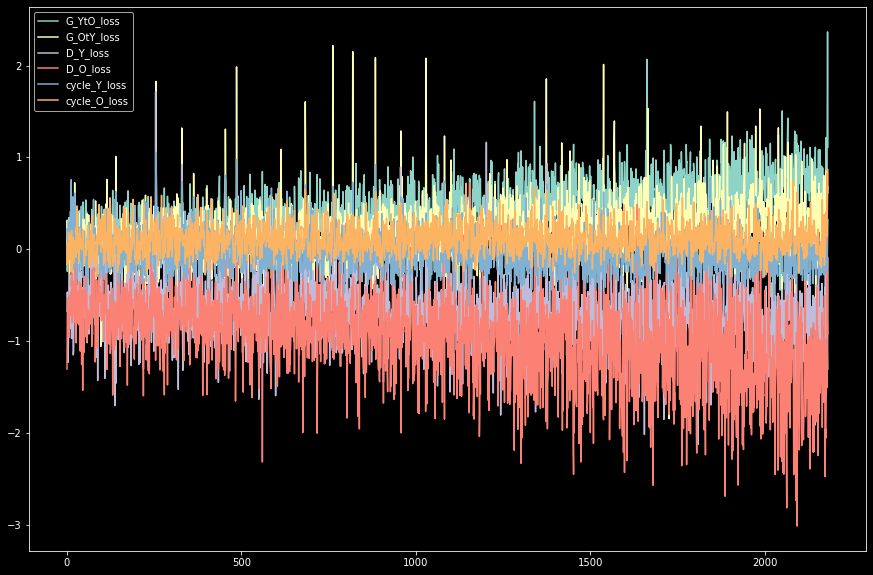

In [92]:
x = np.arange(0,len(G_YtO_losses),1)
fig = plt.figure(1,(15,10))
plt.plot(x,np.log(G_YtO_losses), label = 'G_YtO_loss')
plt.plot(x,np.log(G_OtY_losses), label = 'G_OtY_loss')
plt.plot(x,np.log(D_Y_losses), label = 'D_Y_loss')
plt.plot(x,np.log(D_O_losses), label = 'D_O_loss')
plt.plot(x,np.log(cycle_Y_losses), label = 'cycle_Y_loss')
plt.plot(x,np.log(cycle_O_losses), label = 'cycle_O_loss')
plt.legend()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

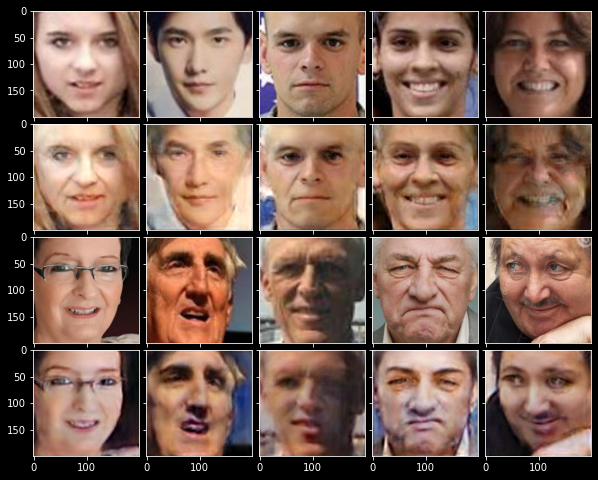

In [203]:
loadnum = '13400'
Y_num = 100
O_num = 65


PATH = './Models/200/OldtoYoung_200_' + loadnum + '.pth'
gen_OtY = GeneratorOldToYoung().to(device)
gen_OtY.load_state_dict(torch.load(PATH))

PATH = './Models/200/YoungtoOld_200_' + loadnum + '.pth'
gen_YtO = GeneratorYoungToOld().to(device)
gen_YtO.load_state_dict(torch.load(PATH))

PATH = './Models/200/Disc_Old_200_' + loadnum + '.pth'
dis_O = DiscriminatorOld().to(device)
dis_O.load_state_dict(torch.load(PATH))

PATH = './Models/200/Disc_Young_200_' + loadnum + '.pth'
dis_Y = DiscriminatorYoung().to(device)
dis_Y.load_state_dict(torch.load(PATH))

im1 = YoungTens[Y_num].permute(1,2,0)
im2 = YoungTens[Y_num+400].permute(1,2,0)
im3 = YoungTens[Y_num+800].permute(1,2,0)
im4 = YoungTens[Y_num+1200].permute(1,2,0)
im5 = YoungTens[Y_num+1600].permute(1,2,0)
im6 = gen_YtO(YoungTens[Y_num:Y_num+1].to(device))[0].permute(1,2,0).detach().to("cpu").numpy()
im7 = gen_YtO(YoungTens[Y_num+400:Y_num+401].to(device))[0].permute(1,2,0).detach().to("cpu").numpy()
im8 = gen_YtO(YoungTens[Y_num+800:Y_num+801].to(device))[0].permute(1,2,0).detach().to("cpu").numpy()
im9 = gen_YtO(YoungTens[Y_num+1200:Y_num+1201].to(device))[0].permute(1,2,0).detach().to("cpu").numpy()
im10 = gen_YtO(YoungTens[Y_num+1600:Y_num+1601].to(device))[0].permute(1,2,0).detach().to("cpu").numpy()
       
im1b = OldTens[O_num].permute(1,2,0)
im2b = OldTens[O_num+200].permute(1,2,0)
im3b = OldTens[O_num+400].permute(1,2,0)
im4b = OldTens[O_num+600].permute(1,2,0)
im5b = OldTens[O_num+800].permute(1,2,0)
im6b = gen_OtY(OldTens[O_num:O_num+1].to(device))[0].permute(1,2,0).detach().to("cpu").numpy()
im7b = gen_OtY(OldTens[O_num+200:O_num+201].to(device))[0].permute(1,2,0).detach().to("cpu").numpy()
im8b = gen_OtY(OldTens[O_num+400:O_num+401].to(device))[0].permute(1,2,0).detach().to("cpu").numpy()
im9b = gen_OtY(OldTens[O_num+600:O_num+601].to(device))[0].permute(1,2,0).detach().to("cpu").numpy()
im10b = gen_OtY(OldTens[O_num+800:O_num+801].to(device))[0].permute(1,2,0).detach().to("cpu").numpy()
       
       
fig = plt.figure(figsize=(10., 10.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                   nrows_ncols=(4, 5),  # creates 2x2 grid of axes
                   axes_pad=0.1,  # pad between axes in inch.
                )
       
for ax, im in zip(grid, [im1, im2, im3, im4,im5,im6,im7,im8,im9,im10,im1b, im2b, im3b, im4b,im5b,im6b,im7b,im8b,im9b,im10b]):
# Iterating over the grid returns the Axes.
    ax.imshow(im, cmap = "Greys")
plt.show()

oty: 6400 13400
yto: 7000 11000 12200
both: 13200

Améliorations:

lambda id = 1 ou 2

features map à 512 dans les residuals (faire x2 à ttes les couches)

residual: chan->chan/2->chan pour fct res1 et res2

reduire les datasets 18-30 et 60-80 (peut être même 50-70 en récupérant).

améliorer disc (patchGAN)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


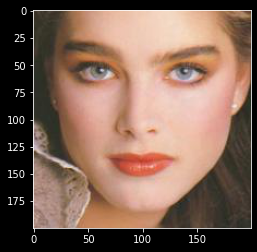

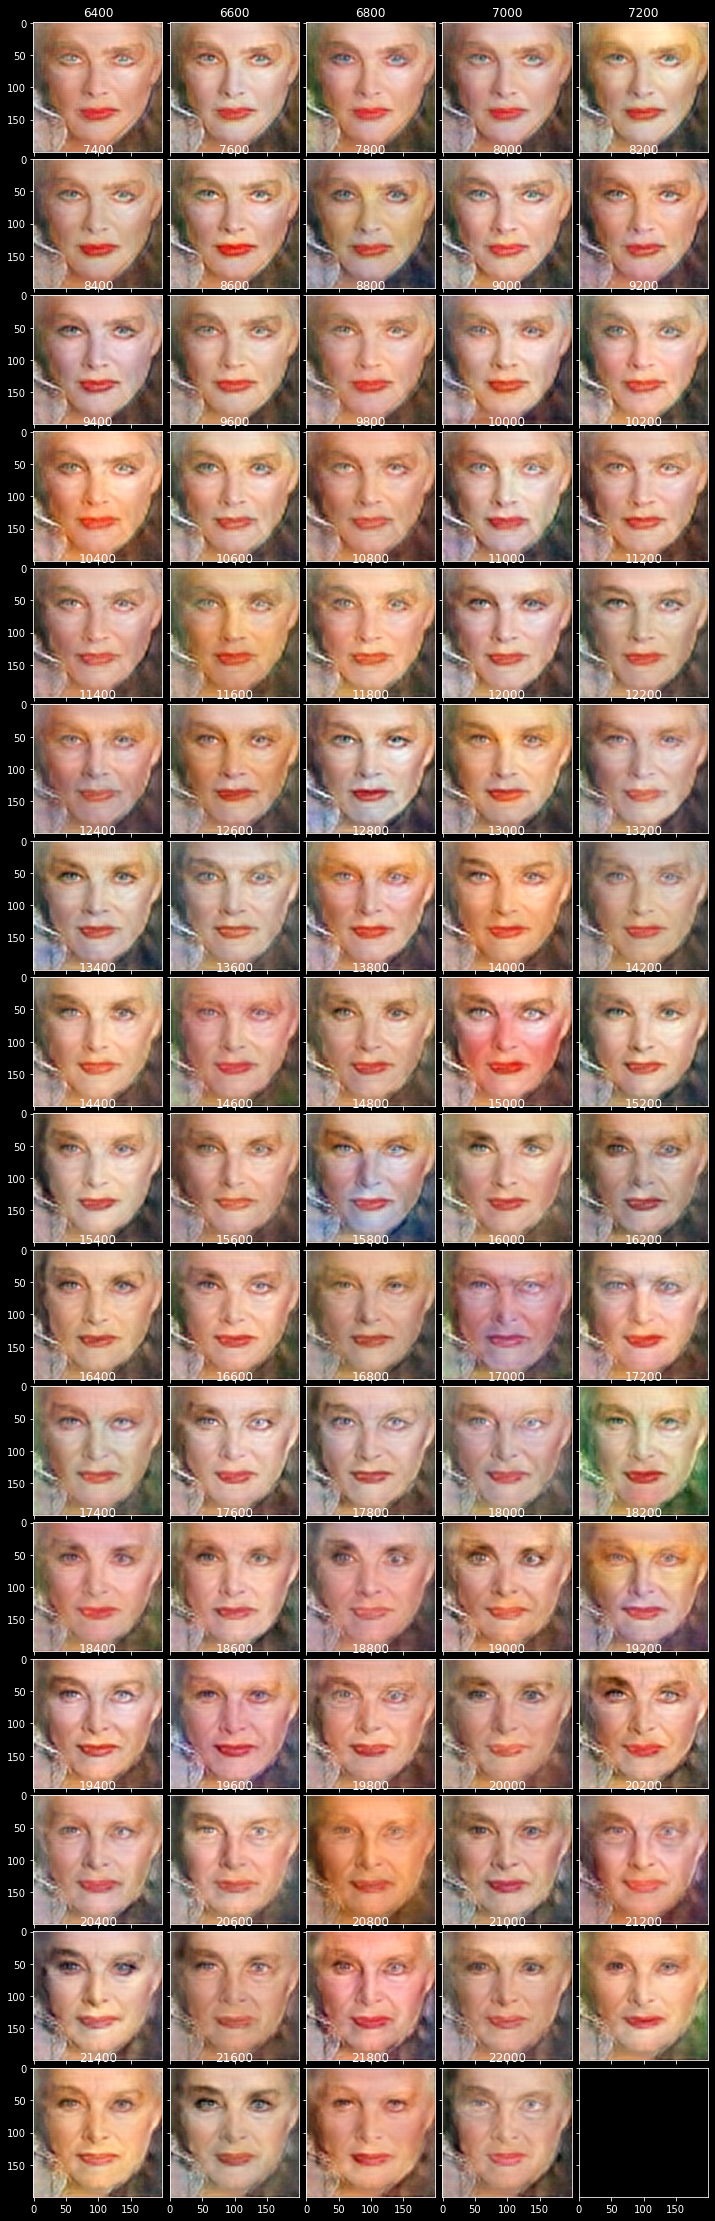

In [144]:
import math

startnum = 6400
endnum = 22000
imnum = 400
mod = np.arange(startnum, endnum+200,200)

plt.imshow(YoungTens[imnum].permute(1,2,0))

nc2 = math.ceil((endnum-startnum)/1000)
fig = plt.figure(figsize=(40., 40.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                   nrows_ncols=(nc2, 5),  # creates 2x2 grid of axes
                   axes_pad=0.1,  # pad between axes in inch.
                )



j = 0
for i in mod:
    
    PATH = './Models/200/YoungtoOld_200_' + str(i) + '.pth'
    gen_YtO = GeneratorYoungToOld().to(device)
    gen_YtO.load_state_dict(torch.load(PATH))

    im = gen_YtO(YoungTens[imnum:imnum+1].to(device))[0].permute(1,2,0).detach().to("cpu").numpy()
    grid[j].imshow(im, cmap = 'Greys')
    grid[j].set_title(str(i))
    j += 1
    

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


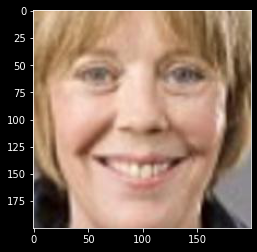

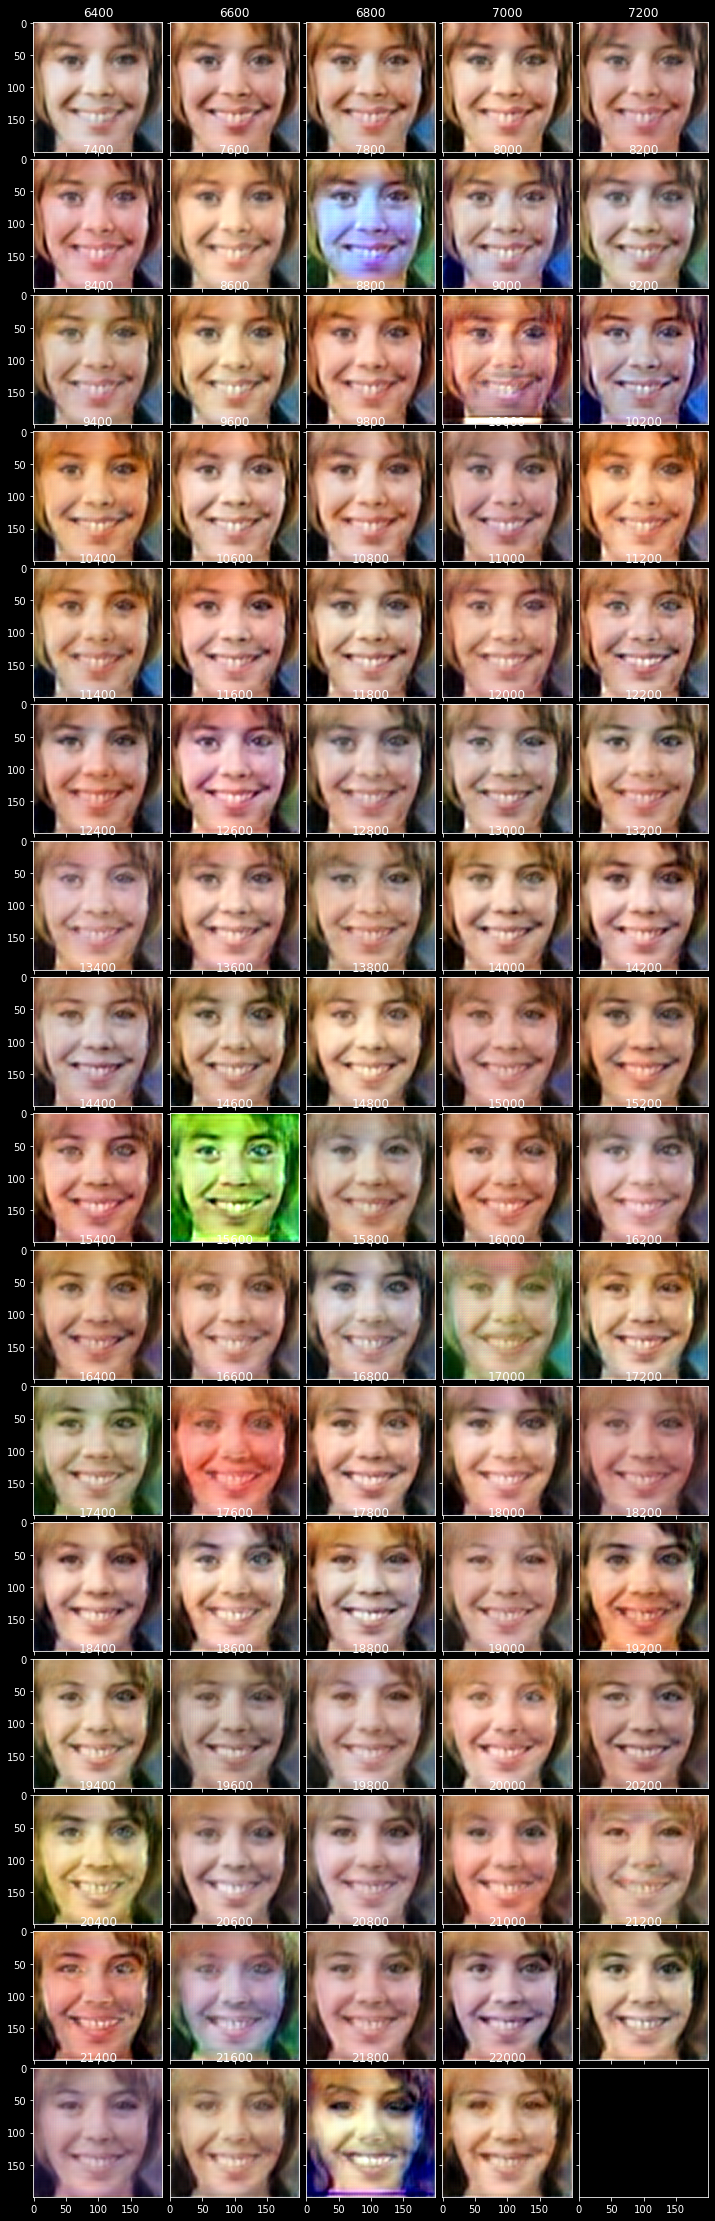

In [164]:
import math

startnum = 6400
endnum = 22000
imnum = 300
mod = np.arange(startnum, endnum+200,200)

plt.imshow(OldTens[imnum].permute(1,2,0))

nc2 = math.ceil((endnum-startnum)/1000)
fig = plt.figure(figsize=(40., 40.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                   nrows_ncols=(nc2, 5),  # creates 2x2 grid of axes
                   axes_pad=0.1,  # pad between axes in inch.
                )



j = 0
for i in mod:
    
    PATH = './Models/200/OldtoYoung_200_' + str(i) + '.pth'
    gen_OtY = GeneratorYoungToOld().to(device)
    gen_OtY.load_state_dict(torch.load(PATH))

    im = gen_OtY(OldTens[imnum:imnum+1].to(device))[0].permute(1,2,0).detach().to("cpu").numpy()
    grid[j].imshow(im, cmap = 'Greys')
    grid[j].set_title(str(i))
    j += 1
    